In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import io

import matplotlib.pyplot as plt

In [2]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

def csv_in_zip(url, outer, csv_name, sep=","):
    response = requests.get(url)
    # if response.raise_for_status():
    #     pass # Ensure the request was successful
    # else:
    #     return
    # Step 2: Extract the outer zip file from the response
    outer_zip = zipfile.ZipFile(io.BytesIO(response.content))
    
    # Step 3: Open the inner zip file from the outer zip (assuming there's one zip file inside)
    inner_zip_name = [name for name in outer_zip.namelist() if name.endswith(outer+'.zip')][0]
    with outer_zip.open(inner_zip_name) as inner_zip_file:
        inner_zip = zipfile.ZipFile(io.BytesIO(inner_zip_file.read()))
    
        # Step 4: Find the CSV file within the inner zip file
        csv_file_name = [name for name in inner_zip.namelist() if name.endswith(csv_name+'.csv')][0]
        with inner_zip.open(csv_file_name) as csv_file:
            # Step 5: Read the CSV file into a pandas DataFrame
            df = pd.read_csv(csv_file, sep=sep)
    return df

In [3]:
df = csv_in_zip(url, 'bank', 'bank-full', ";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data Preparation

In [4]:
data = df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous',
'poutcome','y']] #filtering columns
print(data.isna().sum()) #checking for missing values
data.y = (data.y == 'yes').astype(int)

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


/tmp/ipykernel_2516/3776093785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.y = (data.y == 'yes').astype(int)


In [5]:
# Splitting data
def train_test_val(df, y, test=0.2, val=0.2, random_state=42):
    df_full_train, df_test = train_test_split(df, test_size=test, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size= val/(1-test) , random_state=random_state)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = df_train.y.values
    y_val = df_val.y.values
    y_test = df_test.y.values
    del df_train[y]
    del df_val[y]
    del df_test[y]
    return df_train, df_val, df_test, y_train, y_val, y_test

In [6]:
df_train, df_val, df_test, y_train, y_val, y_test = train_test_val(data, 'y')

### Question 1

In [7]:
# Defining variables
numerical = ['age', 'balance', 'day', 'duration']
def highest_auc(y_train, df_train, variables):
    scores = {}
    for i in variables:
        fpr, tpr, thresholds = roc_curve(y_train, df_train[i])
        if auc(fpr,tpr) < 0.5:
            fpr, tpr, thresholds = roc_curve(y_train, -df_train[i])
            scores[i] = auc(fpr,tpr)
        else:
            scores[i] = auc(fpr,tpr)
    return scores

In [8]:
scores = highest_auc(y_train, df_train, numerical)
scores

{'age': np.float64(0.5072154616891561),
 'balance': np.float64(0.5868318909887845),
 'day': np.float64(0.5250167906149042),
 'duration': np.float64(0.8065630842212128)}

### Question 2

In [9]:
# One-hot encoding of variables
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Calculating accuracy
y_pred = model.predict_proba(X_val)[:, 1]
term_deposit = (y_pred) >= 0.5

In [10]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
round(auc(fpr,tpr), 2)

np.float64(0.91)

### Question 3

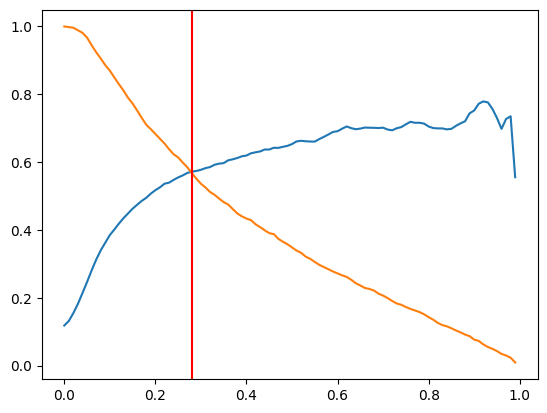

In [11]:
ts = np.linspace(0,0.99,100)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
ps = []
rs = []
for t in ts:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    ps.append(p)
    rs.append(r)
plt.plot(ts,ps)
plt.plot(ts,rs)
idx = np.argwhere(np.isclose(rs, ps, atol=0.01)).flatten()
x_intersect = ts[idx]
plt.axvline(x=x_intersect, color='red')

### Question 4

In [25]:
f1 = {}
for t in ts:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1[str(t)] = (2*(p*r)/(p+r))
print(max(f1, key=f1.get))

0.22


### Question 5